In [180]:
# Specify inline plots for notebook
%matplotlib inline
from matplotlib.font_manager import FontProperties

# Libraries -- overkill for the time being
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime

gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [mcolour, pcolour, pjcolour, jcolour, scolour, gcolour]

# Set working dir
wrkDir = 'C:/Research/AGU_2015/'
# Set Amflux data dir
amfluxDir = 'C:/Research/Ameriflux/'


### Define some linear modeling functions 
#### Grabbed from a couple code blogs

In [ ]:
import matplotlib.dates as dates
from scipy.stats import linregress
def fit_line1(x, y):
    """Return slope, intercept of best fit line."""
    # Remove entries where either x or y is NaN.
    clean_data = pd.concat([x, y], 1).dropna(0) # row-wise
    (_, x), (_, y) = clean_data.iteritems()
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept # could also return stderr

import statsmodels.api as sm
def fit_line2(x, y):
    """Return slope, intercept of best fit line."""
    X = sm.add_constant(x)
    model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    return fit.params[1], fit.params[0] # could also return stderr in each via fit.bse



### Read in process MODIS data for the NMEG
#### The MODIS data here consists of 7x7 km gride surrounding the tower pixel. The data also include a timestamp in the format YYYYDDD, which we convert here to a pandas timestamp for interfacing with the flux data down the road. FInally, for the time being, we just grab NDVI and are still not QCing the data.

In [426]:
import warnings
warnings.filterwarnings('ignore')

VCM = pd.read_csv(wrkDir + 'VCM.csv')
VCMNDVI = VCM[VCM.Band == '250m_16_days_NDVI']
VCMNDVI['Date'] = VCMNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
VCMNDVI.index = VCMNDVI['Date']
VCMNDVI['SITE'] = 'VCM'

VCP = pd.read_csv(wrkDir + 'VCP2.csv', header=None)
VCPNDVI = VCP[VCP[5] == '250m_16_days_NDVI']
VCPNDVI[2] = VCPNDVI[2].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
VCPNDVI.index = VCPNDVI[2]
VCMNDVI['SITE'] = 'VCP'

MPJ = pd.read_csv(wrkDir + 'MPJ2.csv',  header=None)
MPJNDVI = MPJ[MPJ[5] == '250m_16_days_NDVI']
MPJNDVI[2] = MPJNDVI[2].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
MPJNDVI.index = MPJNDVI[2]
VCMNDVI['SITE'] = 'MPJ'


WJS = pd.read_csv(wrkDir + 'JSAV.csv')
WJSNDVI = WJS[WJS.Band == '250m_16_days_NDVI']
WJSNDVI['Date'] = WJSNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
WJSNDVI.index = WJSNDVI['Date']
VCMNDVI['SITE'] = 'WJS'


SES = pd.read_csv(wrkDir + 'SES.csv')
SESNDVI = SES[SES.Band == '250m_16_days_NDVI']
SESNDVI['Date'] = SESNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
SESNDVI.index = SESNDVI['Date']
VCMNDVI['SITE'] = 'SES'


SEG = pd.read_csv(wrkDir + 'SEG.csv')
SEGNDVI = SEG[SEG.Band == '250m_16_days_NDVI']
SEGNDVI['Date'] = SEGNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
SEGNDVI.index = SEGNDVI['Date']
VCMNDVI['SITE'] = 'SEG'

# Subset the center pixel, and take only the NDVI values
VCM = VCMNDVI['397'] 
VCP = VCPNDVI[1624]
MPJ = MPJNDVI[1624] 
WJS = WJSNDVI['397']
SES = SESNDVI['397']
SEG = SEGNDVI['397']

# Make one large dataframe
siteNDVIs = pd.DataFrame(dict(vcm = VCM, vcp = VCP, mpj = MPJ, 
                  wjs = WJS, ses = SES, seg = SEG))

# Create a pandas timestamp for the combined dataframe
dateindex = []
for date in siteNDVIs.index:
    dateindex.append(datetime.datetime.strptime(date, '%Y%j'))
siteNDVIs.index = dateindex

### Read in and process Ameriflux daily data
#### SImilar process here for the Ameriflux data, but the approach is simply to create one giant file, with an added attribute 'SITE' for subplotting and interfacing with the MODIS data.

In [227]:
VCMf_header = pd.read_csv(amfluxDir + 'US-Vcm_2007_2015_daily.txt', sep ='\t').columns
VCMf = pd.read_csv(amfluxDir + 'US-Vcm_2007_2015_daily.txt', sep ='\t', skiprows=1)
VCMf.columns = VCMf_header
VCMf['SITE'] = 'vcm'

VCPf_header = pd.read_csv(amfluxDir + 'US-VCP_2007_2015_daily.txt', sep ='\t').columns
VCPf = pd.read_csv(amfluxDir + 'US-VCP_2007_2015_daily.txt', sep ='\t', skiprows=1)
VCPf.columns = VCPf_header
VCPf['SITE'] = 'vcp'

MPJf_header = pd.read_csv(amfluxDir + 'US-MPJ_2007_2015_daily.txt', sep ='\t').columns
MPJf = pd.read_csv(amfluxDir + 'US-MPJ_2007_2015_daily.txt', sep ='\t', skiprows=1)
MPJf.columns = MPJf_header
MPJf['SITE'] = 'mpj'

WJSf_header = pd.read_csv(amfluxDir + 'US-WJS_2007_2015_daily.txt', sep ='\t').columns
WJSf = pd.read_csv(amfluxDir + 'US-WJS_2007_2015_daily.txt', sep ='\t', skiprows=1)
WJSf.columns = WJSf_header
WJSf['SITE'] = 'wjs'

SESf_header = pd.read_csv(amfluxDir + 'US-SES_2007_2015_daily.txt', sep ='\t').columns
SESf = pd.read_csv(amfluxDir + 'US-SES_2007_2015_daily.txt', sep ='\t', skiprows=1)
SESf.columns = SESf_header
SESf['SITE'] = 'ses'

SEGf_header = pd.read_csv(amfluxDir + 'US-SEG_2007_2015_daily.txt', sep ='\t').columns
SEGf = pd.read_csv(amfluxDir + 'US-SEG_2007_2015_daily.txt', sep ='\t', skiprows=1)
SEGf.columns = SEGf_header
SEGf['SITE'] = 'seg'

fluxdata = pd.concat([VCMf, VCPf, MPJf, WJSf, SESf, SEGf], ignore_index=True)
fluxdata[fluxdata == -9999] = np.nan

# Create a pandas timestamp for the combined dataframe
dateindex = []
yeardoy = []
fluxdata["doy"] = fluxdata["doy"].map("{:03}".format)
for row in fluxdata.index:
    yeardoy.append(str(fluxdata.year[row]) + str(fluxdata.doy[row]))
fluxdata['yeardoy'] = yeardoy

for date in fluxdata.yeardoy:
    dateindex.append(datetime.datetime.strptime(date, '%Y%j'))
fluxdata.index = dateindex

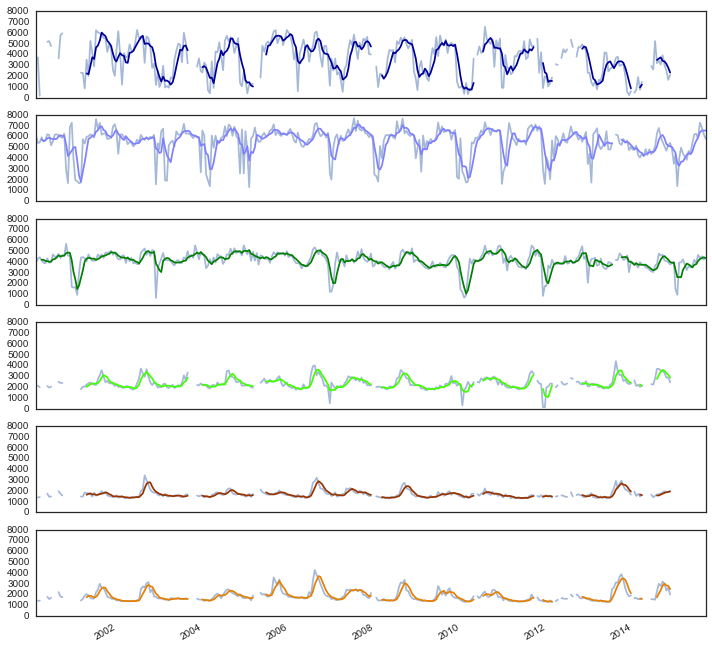

In [427]:
order = ['vcm','vcp','mpj','wjs','ses','seg']
fig, (ax) = plt.subplots(6,1, figsize=(12,12), sharex = True, sharey = True)
axs = fig.axes
idx = 0

for site in order:
    ax = axs[idx]
    siteNDVIs[site].plot(ax = ax, alpha = 0.5)
    pd.rolling_mean(siteNDVIs[site], 4).plot(ax = ax, color = siteColors[idx])
    idx = idx + 1

    

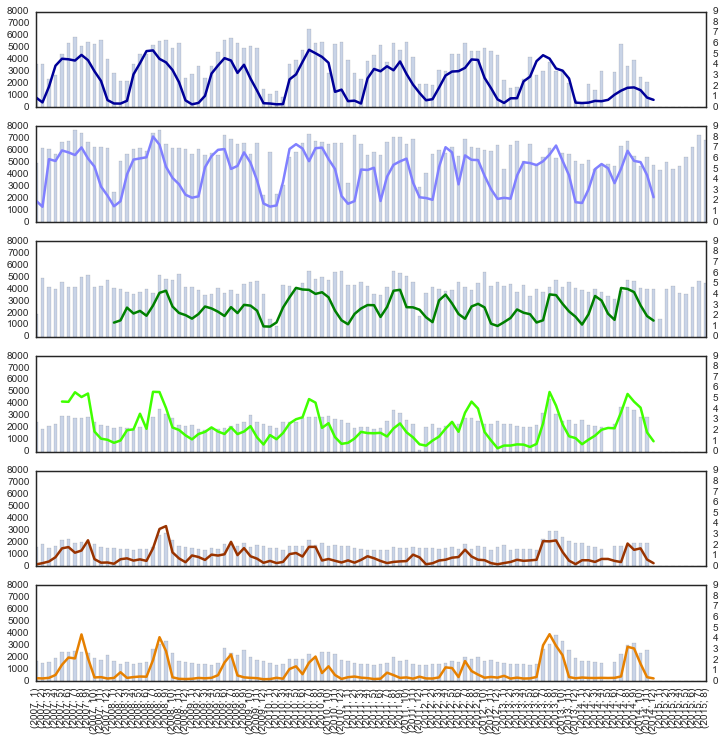

In [428]:
import matplotlib.dates as dates
fig, (ax) = plt.subplots(6,1, figsize=(12,12), sharex = True, sharey = True)
axs = fig.axes
idx = 0
siteNDVIsub = siteNDVIs[siteNDVIs.index.year > 2006]
for site in order:
    ax = axs[idx]
    ax2 = ax.twinx()
    flux = fluxdata[fluxdata.SITE == site]
    siteNDVIsub.groupby([siteNDVIsub.index.year, 
                       siteNDVIsub.index.month])[site].max().plot(ax = ax, 
                       alpha = 0.3, kind = 'bar')
    flux.groupby([flux.index.year, flux.index.month])['GPP'].max().plot(ax = ax2,
                color = siteColors[idx], lw = 2.5)
    ax2.set_ylim([0,9])

    fluxdata
    idx = idx + 1


[None, None, None, None, None, None, None, None, None, None, None, None]

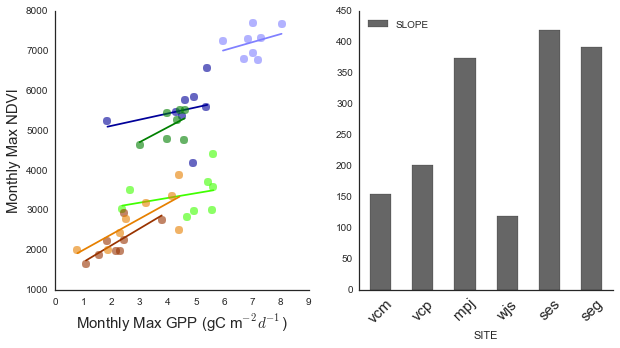

In [429]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,5))
axs = fig.axes
idx = 0
ndvislopes = []
sites = []
siteNDVIsub = siteNDVIsub[siteNDVIsub.index.year < 2015]

for site in order:
    flux = fluxdata[fluxdata.SITE == site]
    flux = flux[flux.index.year < 2015]
    maxf = flux.groupby([flux.index.year]).max()
    maxndvi = siteNDVIsub.groupby([siteNDVIsub.index.year])[site].max()
    
    m, b = fit_line2(maxf.GPP.ravel(), maxndvi.ravel().astype('int'))
    N = 100 # could be just 2 if you are only drawing a straight line...
    points = np.linspace(maxf.GPP.min(), maxf.GPP.max(), N)
    ax.plot(points, m*points + b, color = siteColors[idx])

    ax.plot(maxf.GPP.ravel(), maxndvi.ravel(), color = siteColors[idx], 
            marker='o', linestyle='', ms = 8, alpha = 0.6)
    ndvislopes.append(m)
    sites.append(site)
    idx = idx + 1
sns.despine()
ax.set_xlabel('Monthly Max GPP (gC m$^{-2} d^{-1}$)', fontsize = 15)
ax.set_ylabel('Monthly Max NDVI', fontsize = 15)

ndviresp = pd.DataFrame(dict(SITE = sites, SLOPE = ndvislopes))
ndviresp.plot(x = 'SITE', kind = 'bar', ax = ax2, color = ['black'], alpha = 0.6)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize = 15)

In [430]:
maxndvi = ndviyear.groupby([ndviyear.index.month])[site].max()
toPlot = pd.DataFrame(dict(x = maxf.GPP, y = maxndvi))
toPlot.dropna().x

Series([], Name: x, dtype: float64)

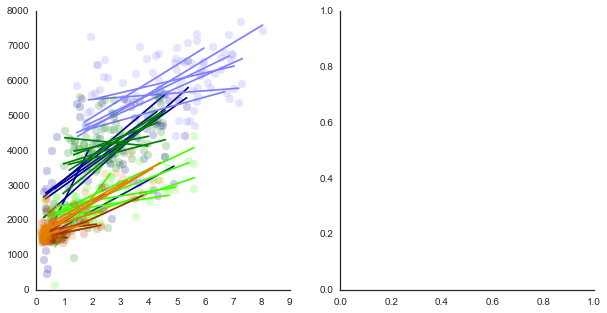

In [433]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,5))
axs = fig.axes
idx = 0
ndvislopes = []
sites = []
siteNDVIsub = siteNDVIsub[siteNDVIsub.index.year < 2015]
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014]
for site in order:
    flux = fluxdata[fluxdata.SITE == site]
    flux = flux[flux.index.year < 2015]
    for year in years:
        fluxyear = flux[flux.index.year == year]
        maxf = fluxyear.groupby([fluxyear.index.month]).max()
        ndviyear = siteNDVIsub[siteNDVIsub.index.year == year]
        maxndvi = ndviyear.groupby([ndviyear.index.month])[site].max()
        toPlot = pd.DataFrame(dict(x = maxf.GPP, y = maxndvi))
        m, b = fit_line2(toPlot.dropna().x, toPlot.dropna().y)
        N = 100 # could be just 2 if you are only drawing a straight line...
        points = np.linspace(maxf.GPP.min(), maxf.GPP.max(), N)
        ax.plot(points, m*points + b, color = siteColors[idx])

        ax.plot(maxf.GPP, maxndvi, color = siteColors[idx], 
                marker='o', linestyle='', ms = 8, alpha = 0.2)
    idx = idx + 1
sns.despine()
